### Import libraries 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
from theano.printing import pydotprint

import seaborn as sns 
import os
import sys

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import our own library functions

In [3]:
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
os.chdir("../../")
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
import import_folders

# Own graphical library
from graph_lib import gl
import utilities_lib as ul

Base path: /home/montoya/Desktop/bolsa/Trapyng/Code


### Own options and configurations

In [4]:
folder_images = "../pics/HBM/example_AB/"
ul.create_folder_if_needed(folder_images)

##  1) Two Groups with Continiuous Outcome

To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

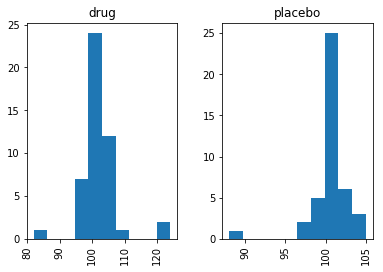

In [5]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group. This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. 


### Prior choice

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

Similarly, we will use a uniform prior for the standard deviations, with an upper bound of 20.
For the degrees-of-freedom parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [10]:
with pm.Model() as drug_model:
    ## Priors
    μ_0 = pm.Normal('μ_0', 100, sd=10)
    μ_1 = pm.Normal('μ_1', 100, sd=10)
    
    σ_0 = pm.Uniform('σ_0', lower=0, upper=20)
    σ_1 = pm.Uniform('σ_1', lower=0, upper=20)
    
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1
    
    ## Model 
    
    drug_like = pm.StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**-2, observed=drug.iq)
    placebo_like = pm.StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**-2, observed=placebo.iq)

Now that the model is fully specified, we can turn our attention to tracking the posterior quantities of interest. Namely, we can calculate the difference in means between the drug and placebo groups.

As a joint measure of the groups, we will also estimate the "effect size", which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but it is a function of all four estimated parameters.

In [11]:
with drug_model:
    
    diff_of_means = pm.Deterministic('difference of means', μ_1 - μ_0)
    
    effect_size = pm.Deterministic('effect size', 
                        diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))



In [14]:
RANDOM_SEED = 200
with drug_model:
    
    drug_trace = pm.fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 245.01: 100%|██████████| 10000/10000 [00:06<00:00, 1560.78it/s]
Finished [100%]: Average Loss = 244.98


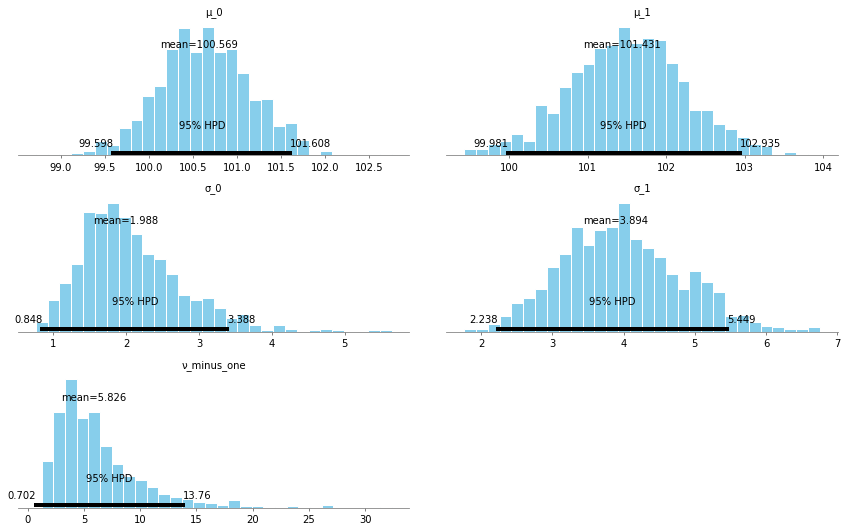

In [16]:
pm.plot_posterior(drug_trace[100:], 
                varnames=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');

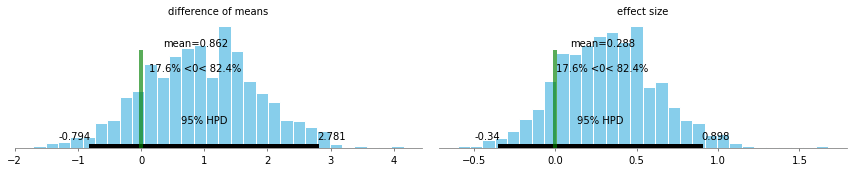

In [18]:
pm.plot_posterior(drug_trace[100:], 
          varnames=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is 0.99.

## Two Groups with Binary Outcome

Now that we have seen how to generalize normally-distributed data to another distribution, we are equipped to analyze other data types. Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

> *Never, ever dichotomize continuous or ordinal variables prior to statistical analysis*

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

Such events are sometimes reported as sums of individual events, such as the number of individuals in a group who test positive for a condition of interest. Sums of Bernoulli events are distributed as **binomial** random variables.

$$f(x \mid n, p) = \binom{n}{x} p^x (1-p)^{n-x}$$

The parameter in both models is $p$, the probability of the occurrence of an event. In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

![](images/ivh.gif)

In [44]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with a pneumothorax. 

In [45]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [46]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

### Prior choice

What should we choose as a prior distribution for $p$?

We could stick with a normal distribution, but note that the value of $p$ is **constrained** by the laws of probability. Namely, we cannot have values smaller than zero nor larger than one. So, choosing a normal distribution will result in ascribing positive probability to unsupported values of the parameter. In many cases, this will still work in practice, but will be inefficient for calculating the posterior and will not accurately represent the prior information about the parameter.

A common choice in this context is the **beta distribution**, a continuous distribution with 2 parameters and whose support is on the unit interval:


So let's use a beta distribution to model our prior knowledge of the probabilities for both groups. Setting $\alpha = \beta = 1$ will result in a uniform distribution of prior mass:

In [48]:
with Model() as ivh_model:
    
    p = pm.Beta('p', 1, 1, shape=2)
    
     bb_like = pm.Bernoulli('bb_like', p=p[x], observed=ivh)

We can now use `p` as the parameter of our Bernoulli likelihood. Here, `x` is a vector of zeros an ones, which will extract the approproate group probability for each subject:

Finally, since we are interested in the difference between the probabilities, we will keep track of this difference:

In [19]:
with ivh_model:
    
    p_diff = Deterministic('p_diff', p[1] - p[0])

NameError: name 'ivh_model' is not defined

In [51]:
with ivh_model:
    ivh_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 226.28: 100%|██████████| 10000/10000 [00:00<00:00, 13352.85it/s]
Finished [100%]: Average Loss = 226.28


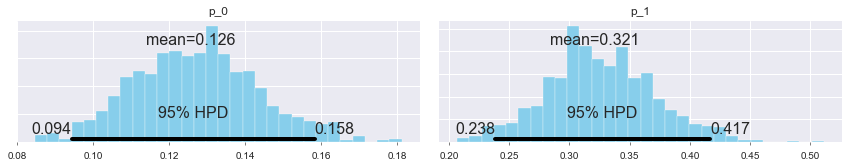

In [52]:
plot_posterior(ivh_trace[100:], varnames=['p'], color='#87ceeb');

We can see that the probability that `p` is larger for the pneumothorax with probability one.

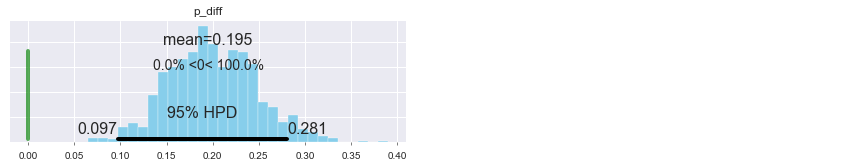

In [53]:
plot_posterior(ivh_trace[100:], varnames=['p_diff'], ref_val=0, color='#87ceeb');